# 4.1 타이타닉의 생존자 가려내기

## Step 1 탐색: 타이타닉 데이터 살펴보기

타이타닉 데이터셋의 구성은 다음과 같다.
* pclass: 승객 등급
* survived: 생존 여부(생존은 1, 아닌 경우는 0)
* name: 승객 이름
* sex: 승객 성별
* age: 승객 나이
* sibsp: 동승한 형제 또는 배우자 수
* parch: 동승한 부모 또는 자녀 수
* ticket: 티켓 번호
* fare: 승객 지불 요금
* cabin: 선실 이름
* embarked: 승선항(C=쉘 부르크, Q=퀸즈타운, S=사우스 햄튼)
* body: 사망자 확인 번호
* home.dest: 고향/목적지

분석에 사용할 데이터는 학습 데이터셋과 테스트 데이터셋 2개의 파일로 구성되어 있다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_train = pd.read_csv('data/titanic_train.csv')
df_test = pd.read_csv('data/titanic_test.csv')
df_train.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,body,home.dest
0,2,1,"Mellinger, Miss. Madeleine Violet",female,13.0,0,1,250644,19.5000,NaN,S,NaN,"England / Bennington, VT"
1,2,1,"Wells, Miss. Joan",female,4.0,1,1,29103,23.0000,NaN,S,NaN,"Cornwall / Akron, OH"
2,2,1,"Duran y More, Miss. Florentina",female,30.0,1,0,SC/PARIS 2148,13.8583,NaN,C,NaN,"Barcelona, Spain / Havana, Cuba"
3,3,0,"Scanlan, Mr. James",male,NaN,0,0,36209,7.7250,NaN,Q,NaN,NaN
4,3,1,"Bradley, Miss. Bridget Delia",female,22.0,0,0,334914,7.7250,NaN,Q,NaN,"Kingwilliamstown, Co Cork, Ireland Glens Falls..."


In [2]:
print(df_train.info())
print("--------------------------")
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     916 non-null    int64  
 1   survived   916 non-null    int64  
 2   name       916 non-null    object 
 3   sex        916 non-null    object 
 4   age        741 non-null    float64
 5   sibsp      916 non-null    int64  
 6   parch      916 non-null    int64  
 7   ticket     916 non-null    object 
 8   fare       916 non-null    float64
 9   cabin      214 non-null    object 
 10  embarked   914 non-null    object 
 11  body       85 non-null     float64
 12  home.dest  527 non-null    object 
dtypes: float64(3), int64(4), object(6)
memory usage: 93.2+ KB
None
--------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass    

먼저 name, ticket, body, home.dest, cabin 피처를 제거한다. -> 분석에 활용될 수 없기 때문

In [3]:
df_train = df_train.drop(['name', 'ticket', 'body', 'home.dest', 'cabin'], axis=1)
df_test = df_test.drop(['name', 'ticket', 'body', 'home.dest', 'cabin'], axis=1)

생존자 그룹과 비생존자 그룹으로 나누어 피처의 그룹간 차이를 탐색해보자.

그룹 비율은 5:3 정도 나타났고, 그룹별 pclass 분포는 상이하게 나타났다. 이를 통해 pclass 피처는 생존자 분류에 유의미한 영향을 미친다는 가설을 세워 볼 수 있다.

survived
0    563
1    353
Name: count, dtype: int64


<Axes: xlabel='survived', ylabel='count'>

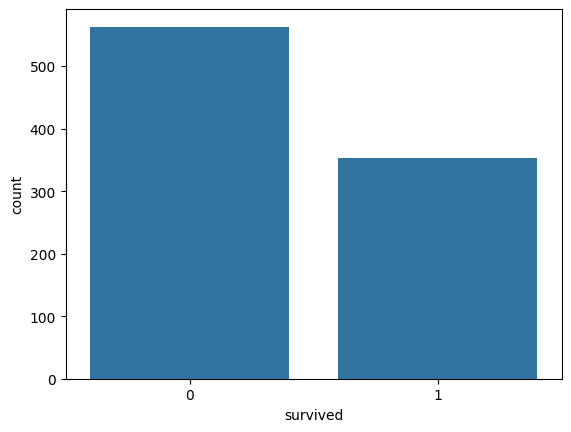

In [4]:
print(df_train['survived'].value_counts())

#df_train['survived'].value_counts().plot.bar()
sns.countplot(x=df_train['survived'])

<Axes: xlabel='pclass', ylabel='count'>

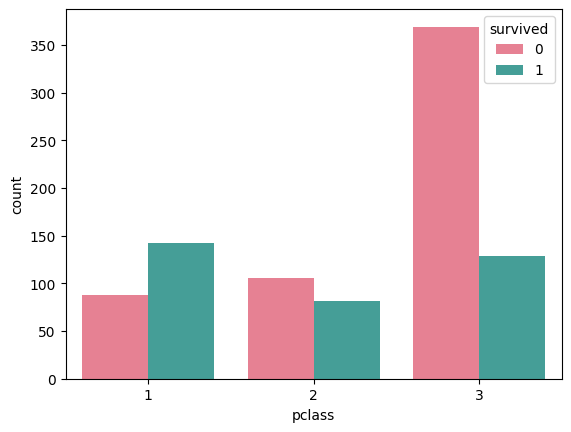

In [5]:
# survived 피처를 기준으로 그룹을 나누어 그룹별 pclass 피처의 분포를 살펴보자.
sns.countplot(data=df_train, x=df_train['pclass'], hue='survived', palette='husl')

다음으로 age, sibsp 같은 수치형 피처들에 대한 탐색을 진행해보자. 아래의 코드는 이러한 피처들을 탐색할 수 있는 자동화 함수 valid_features()를 작성한 것이다. 함수가 실행하는 내용은 아래와 같다.
* 두 그룹 간의 분포를 비교한느 그래프를 출력
* 두 그룹 각각의 표준편차를 출력
* 두 그룹 간의 T-test 검정을 실시하여 출력
* 두 그룹 각각에 Shapiro-wilk 검정을 실시하여 출력

In [6]:
from scipy import stats

# 두 집단의 피처를 비교해주며 탐색 작업을 자동화하는 함수를 정의
def valid_feature(df, col_name, distribution_check=True):

    # 두 집단 (survived=1, survived=0)의 분포 그래프를 출력
    g = sns.FacetGrid(df, col='survived')
    g.map(plt.hist, col_name, bins=30)

    # 두 집단 (survived=1, survived=0)의 표준편차를 각각 출력
    titanic_survived = df[df['survived'] == 1]
    titanic_survived_static = np.array(titanic_survived[col_name])
    print('data std is', '%.2f' % np.std(titanic_survived_static))
    titanic_n_survived = df[df['survived'] == 0]
    titanic_n_survived_static = np.array(titanic_n_survived[col_name])
    print('data std is', '%.2f' % np.std(titanic_n_survived_static))

    # T-test로 두 집단의 평균 차이를 검정
    tTestResult = stats.ttest_ind(titanic_survived[col_name], titanic_n_survived[col_name])
    tTestResultDiffVar = stats.ttest_ind(titanic_survived[col_name], titanic_n_survived[col_name], equal_var=False)
    print("The t-statistic and p-value assuming equal variances is %.3f and %.3f" %tTestResult)
    print("The t-statistic and p-value not assuming equal variances is %.3f and %.3f" %tTestResultDiffVar)

    if distribution_check:
        # Shapiro-Wilk 검정: 분포의 정규성 정도를 검증
        print("The w-statistic and p-value in Survived %.3f and %.3f" %stats.shapiro(titanic_survived[col_name]))
        print("The w-statistic and p-value in Non-Survived %.3f and %.3f" %stats.shapiro(titanic_n_survived[col_name]))

아래의 실행 결과는 valid_features()를 실행한 것이다. 이를 통해 살펴본 피처는 age, sibsp 두 피처이다.

data std is 14.22
data std is 13.71
The t-statistic and p-value assuming equal variances is -0.546 and 0.585
The t-statistic and p-value not assuming equal variances is -0.543 and 0.587
The w-statistic and p-value in Survived 0.982 and 0.001
The w-statistic and p-value in Non-Survived 0.968 and 0.000


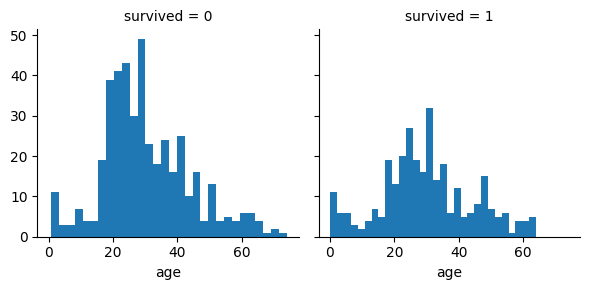

In [7]:
valid_feature(df_train[df_train['age'] > 0], 'age', distribution_check=True)

data std is 0.64
data std is 1.34
The t-statistic and p-value assuming equal variances is -2.118 and 0.034
The t-statistic and p-value not assuming equal variances is -2.446 and 0.015


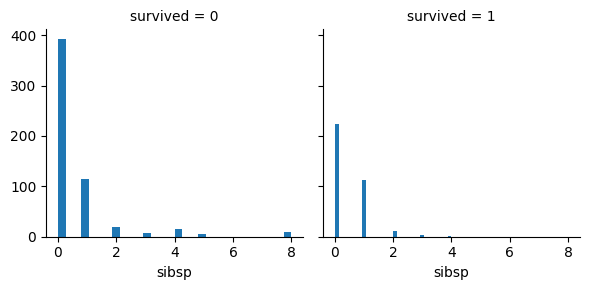

In [8]:
valid_feature(df_train, 'sibsp', distribution_check=False)

분석 결과, age 피처는 두 그룹 간의 평균 차이가 없기 때문에 생존자 분류에 미치는 영향력이 낮을 것이라고 가정해볼 수 있다. 반면 sibsp 피처에서는 두 그룹 간의 평균 차이가 어느 정도 존재하는 것을 알 수 있다.

### 미니퀴즈 4-1

parch, fare, sex, embarked 피처에 대해 생존자/비생존자 간의 차이를 탐색해보자
위의 동일한 방법을 이용하여 생존자와 비생존자 그룹 간의 평균과 분포가 어떻게 다른지, 통계적 유의성이 얼마나 있는지 살펴보자

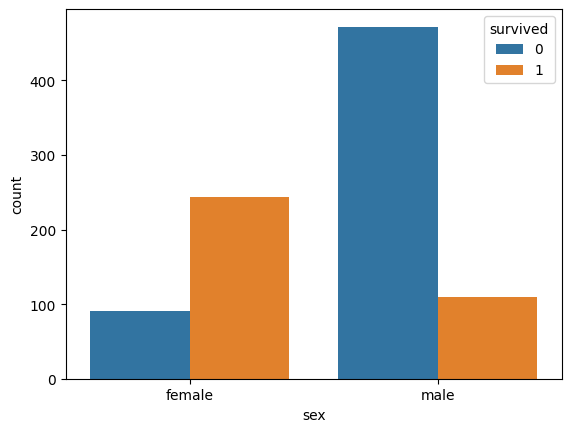

In [9]:
ax = sns.countplot(data=df_train, x='sex', hue='survived')

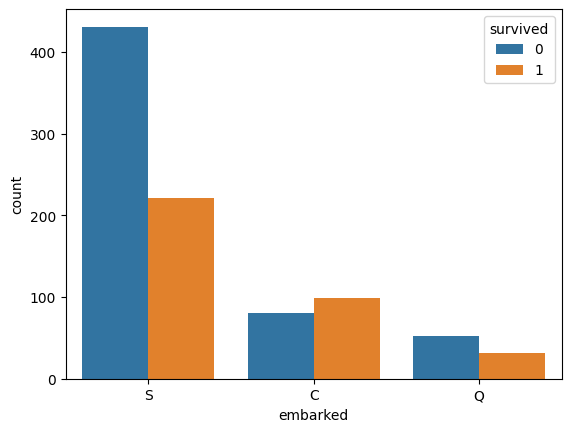

In [10]:
ax = sns.countplot(data=df_train, x='embarked', hue='survived')

data std is 0.74
data std is 0.89
The t-statistic and p-value assuming equal variances is 1.865 and 0.063
The t-statistic and p-value not assuming equal variances is 1.942 and 0.052


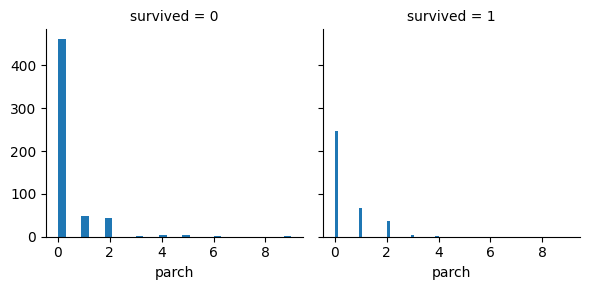

In [11]:
valid_feature(df_train, 'parch', distribution_check=False)

data std is 60.68
data std is 33.65
The t-statistic and p-value assuming equal variances is 7.523 and 0.000
The t-statistic and p-value not assuming equal variances is 6.657 and 0.000


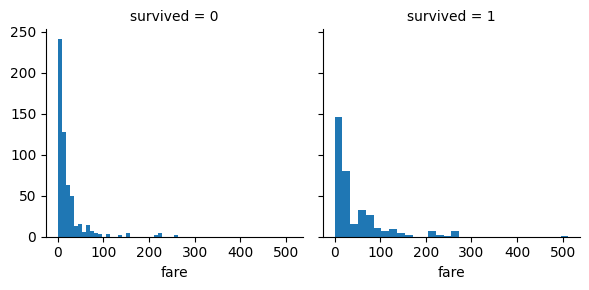

In [12]:
valid_feature(df_train, 'fare', distribution_check=False)

## Step 2 분류: 생존자 분류 모델 만들기

첫 번째로 시도해볼 방법은 **로지스틱 회귀 모델**을 이용한 분류이다.

우선 결측값을 처리해야 하는데 크게 2가지 방법이 있다.
1, 결측이 존재하는 데이터를 삭제
2. 평균값, 혹은 중앙값이나 최빈값 등의 임의의 수치로 채움

두 가지 장단점이 있는데 아래의 코드는 2번을 이용하여 결측값을 보정하였다

In [13]:
# age 결측값을 평균값으로 대체
replace_mean = df_train[df_train['age'] > 0]['age'].mean()
df_train['age'] = df_train['age'].fillna(replace_mean)
df_test['age'] = df_test['age'].fillna(replace_mean)

# embark : 2개의 결측값을 최빈값으로 대체
embarked_mode = df_train['embarked'].value_counts().index[0]
df_train['embarked'] = df_train['embarked'].fillna(embarked_mode)
df_test['embarked'] = df_test['embarked'].fillna(embarked_mode)

# 원-핫 인코딩을 위한 통합 데이터 프레임(whole_df)를 생성
whole_df = pd.concat([df_train, df_test])
train_idx_num = len(df_train)

# pandas 패키지를 이용한 원-핫 인코딩을 수행
whole_df_encoded = pd.get_dummies(whole_df)
df_train = whole_df_encoded[:train_idx_num]
df_test = whole_df_encoded[train_idx_num:]

df_train.head()

,pclass,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,2,1,13.000000,0,1,19.5000,True,False,False,False,True
1,2,1,4.000000,1,1,23.0000,True,False,False,False,True
2,2,1,30.000000,1,0,13.8583,True,False,True,False,False
3,3,0,30.231444,0,0,7.7250,False,True,False,True,False
4,3,1,22.000000,0,0,7.7250,True,False,False,True,False


In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 916 entries, 0 to 915
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pclass      916 non-null    int64  
 1   survived    916 non-null    int64  
 2   age         916 non-null    float64
 3   sibsp       916 non-null    int64  
 4   parch       916 non-null    int64  
 5   fare        916 non-null    float64
 6   sex_female  916 non-null    bool   
 7   sex_male    916 non-null    bool   
 8   embarked_C  916 non-null    bool   
 9   embarked_Q  916 non-null    bool   
 10  embarked_S  916 non-null    bool   
dtypes: bool(5), float64(2), int64(4)
memory usage: 54.6 KB


이제 sklearn 모듈의 LogisticRegression 클래스로 모델을 학습해보자.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 데이터를 학습 데이터셋, 테스트데이터셋으로 분리
x_train, y_train = df_train.loc[:, df_train.columns != 'survived'].values, df_train['survived'].values
x_test, y_test = df_test.loc[:, df_test.columns != 'survived'].values, df_test['survived'].values

# 로지스텍 회귀 모델을 학습
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)

# 테스트 데이터셋에 대한 예측 결과를 반환
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

C:\Users\CHOYS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


이 모델이 생존자를 얼마나 잘 분류하는지 어떻게 평가할까? 일반적으로 분류 모델의 평가 기준은 **Confusion Matrix**를 활용한다. 아래는 구성 요소이다.
* True Positives: 1인 값을 1이라 하는 경우(정확하게 분류)
* False Negatives: 1인 값을 0이라 하는 경우(잘못 분류)
* False Positives: 0인 값을 1이라 하는 경우(잘못 분류)
* True Negatives: 0인 값을 0이라 하는 경우(정확하게 분류)

위의 정보를 이용해 정확도, 정밀도, 재현도, 특이도를 계산한다.

그리고 또 위를 활용해서 평가한 지표가 **F1-score**와 **ROC Curve**이다

In [16]:
# 테스트 데이터셋에 대한 정확도, 정밀도, 재현도, f1 평가 지표를 각각 출력
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision: %.3f" % precision_score(y_test, y_pred))
print("Recall: %.3f" % recall_score(y_test, y_pred))
print("F1: %.3f" % f1_score(y_test, y_pred))

accuracy: 0.80
Precision: 0.756
Recall: 0.673
F1: 0.712


아래의 코드는 Confusion Matrix를 출력한 것이다.

In [17]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[214  32]
 [ 48  99]]


마지막으로 AUC를 출력해보자. AUC 출력은 분류 결과인 0 혹인 1의 y값(y_pred)를 사용하는 것이 아닌, 분류 직전의 확률값(y_pred_probability)인 0~1 사이의 값을 사용해야 한다. 아래 코드는 AUC와 ROC Curve를 그래프로 나타낸 것이다.

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score

# AUC를 계산하여 출력
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" %roc_auc)

AUC : 0.838


AUC가 약 0.837로, 생존자를 잘 분류해내는 모델이라 할 수 있다.

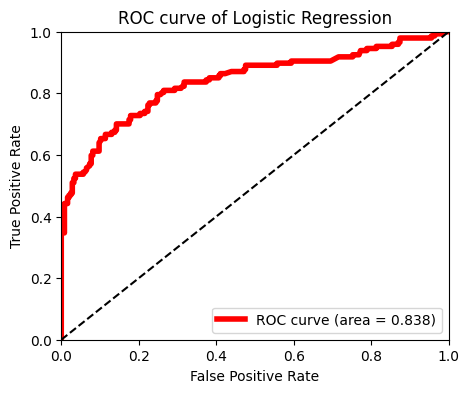

In [19]:
# ROC Curve를 그래프로 출력
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %.3f)' %roc_auc, color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic Regression')
plt.legend(loc='lower right')

아래의 코드는 의사결정 나무 모델을 적용한 결과이다. 하지만 로지스텍 회귀 모델에 비해 모든 평가 지표가 낮은 것을 확인할 수 있다.

accuracy: 0.75
Precision: 0.667
Recall: 0.639
F1: 0.653
AUC : 0.738


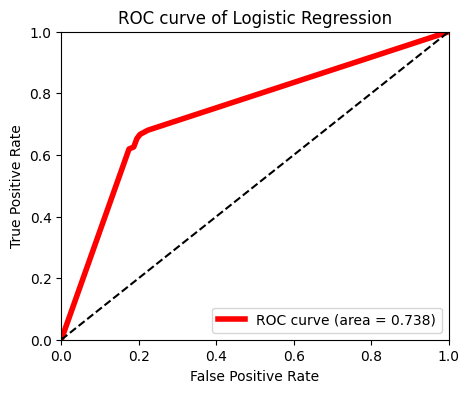

In [20]:
from sklearn.tree import DecisionTreeClassifier

# 의사결정나무를 학습하고, 학습한 모델로 테스트 데이터셋에 대한 예측값을 반환
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
y_pred_probability = dtc.predict_proba(x_test)[:,1]

# 학습한 모델의 성능을 계산하여 출력
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision: %.3f" % precision_score(y_test, y_pred))
print("Recall: %.3f" % recall_score(y_test, y_pred))
print("F1: %.3f" % f1_score(y_test, y_pred))

# 학습한 모델의 AUC를 계산하여 출력
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" %roc_auc)

# ROC curve를 그래프로 출력
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %.3f)' %roc_auc, color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic Regression')
plt.legend(loc='lower right')

## Step 3: 모델 개선: 피처 엔지니어링 첫걸음

분류 모델의 성능을 더욱 끌어올리기 위해서는 어떻게 해야 할까? 분석가가 사용하는 무기는 바로 **피처 엔지니어링**이다. 이는 모델에 사용할 피처를 가공하는 분석 작업을 의미한다. 이를 수행하기 위해 분석 과정을 처음부터 다시 시작하자.

In [21]:
# 데이터를 다시 불러온다.
df_train = pd.read_csv('data/titanic_train.csv')
df_test = pd.read_csv('data/titanic_test.csv')
df_train = df_train.drop(['ticket', 'body', 'home.dest'], axis=1)
df_test = df_test.drop(['ticket', 'body', 'home.dest'], axis=1)

# age 결측값을 평균값으로 대체
replace_mean = df_train[df_train['age'] > 0]['age'].mean()
df_train['age'] = df_train['age'].fillna(replace_mean)
df_test['age'] = df_test['age'].fillna(replace_mean)

# embark: 2개의 결측값을 최빈값으로 대체
embarked_mode = df_train['embarked'].value_counts().index[0]
df_train['embarked'] = df_train['embarked'].fillna(embarked_mode)
df_test['embarked'] = df_test['embarked'].fillna(embarked_mode)

# 원-핫 인코딩을 위한 통합 데이터 프레임(whole_df)를 생성
whole_df = pd.concat([df_train, df_test])
train_idx_num = len(df_train)

이번에는 cabin 피처와 name 피처를 가공하여 분석에 포함한다. cabin 피처는 선실의 정보를 나타내는 데이터로, 선실을 대표하는알파벳이 첫 글자에 등장한다는 패턴을 가지고 있다.

In [22]:
print(whole_df['cabin'].value_counts()[:10])

cabin
C23 C25 C27        6
B57 B59 B63 B66    5
G6                 5
F4                 4
B96 B98            4
F33                4
C78                4
D                  4
F2                 4
C22 C26            4
Name: count, dtype: int64


이 피처의 결측 데이터는 알파벳이 없다는 의미의 'X' 알파벳으로 채워준다. 그리고 데이터의 수가 매우 적은 G와 T 역시 'X'로 대체한다.

선실 별 생존자 여부를 시각화해보면 아래 그래프와 같다.

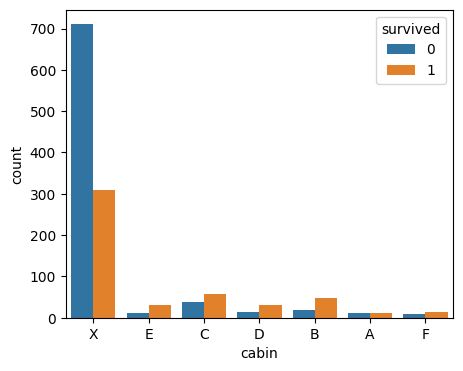

In [23]:
# 결측데이터를 'X'로 대체
whole_df['cabin'] = whole_df['cabin'].fillna('X')

# cabin 피처의 첫 번쨰 알파벳을 추출
whole_df['cabin'] = whole_df['cabin'].apply(lambda x: x[0])

# G와 T 역시 'X'로 대체
whole_df['cabin'] = whole_df['cabin'].replace({"G":"X", "T":"X"})

ax = sns.countplot(data = whole_df, x = 'cabin', hue = 'survived')
plt.show()

다음으로 name 피처를 살펴보자. 이름을 어떻게 피처로 사용할까 생각할 수 있는데, 데이터를 자세히 살펴보면 공통점을 발견할 수 있다. 바로, 이름 구성 중간에 들어가는 **호칭** 정보이다.

예로, Bradley, Miss. Bridget Delia를 보면 Miss가 호칭이다. 당시 시대는 사회적 계급이 존재하였기 때문에 호칭 정보는 매우 중요한 데이터로 활용될 수 있다.

In [24]:
# 이름에서 호칭을 추출
name_grade = whole_df['name'].apply(lambda x: x.split(", ")[1].split(". ")[0])
name_grade = name_grade.unique().tolist()
print(name_grade)

['Miss', 'Mr', 'Master', 'Mrs', 'Dr', 'Mlle', 'Col', 'Rev', 'Ms', 'Mme', 'Sir', 'the Countess', 'Dona', 'Jonkheer', 'Lady', 'Major', 'Don', 'Capt']


In [25]:
# 호칭에 따라 사회적 지위를 정의
grade_dict = {
    'A': ['Rev', 'Col', 'Major', 'Dr', 'Capt', 'Sir'], # 명예직
    'B': ['Ms', 'Mme', 'Mrs', 'Dona'], # 여성
    'C': ['Jonkheer', 'the Countess'], # 귀족이나 작위
    'D': ['Mr', 'Don'], # 남성
    'E': ['Master'], # 젊은 남성
    'F': ['Miss', 'Mile', 'Lady']} # 젊은 여성

# 정의한 호칭의 기준에 따라 A-F의 문자로 name 피처를 다시 정의하는 함수
def give_grade(x):
    grade = x.split(", ")[1].split(". ")[0]
    for (key,value) in grade_dict.items():
        if grade in value:
            return key

    return 'G'

# 위의 함수를 적용하여 name 피처를 새롭게 정의
whole_df['name'] = whole_df['name'].apply(lambda x: give_grade(x))
print(whole_df['name'].value_counts())

name
D    758
F    261
B    201
E     61
A     24
G      2
C      2
Name: count, dtype: int64


### 미니 퀴즈 4-2

name 피처에 대해 생존자/비생존자 그룹 간의 차이를 탐색해보자

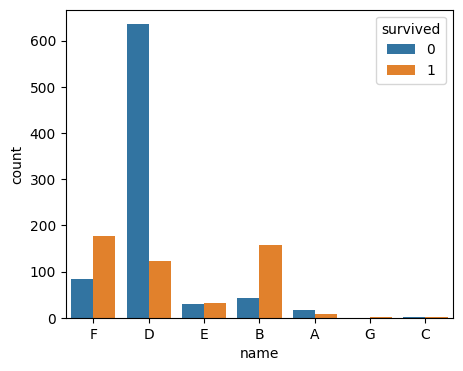

In [26]:
ax = sns.countplot(data=whole_df, x='name', hue='survived')
plt.show()

이제 모델을 학습하기 위한 마지막 전처리 단계로 모든 범주형 피처들에 원-핫 인코딩을 적용한다

In [27]:
whole_df_encoded = pd.get_dummies(whole_df)
df_train = whole_df_encoded[:train_idx_num]
df_test = whole_df_encoded[train_idx_num:]
df_train.head()

,pclass,survived,age,sibsp,parch,fare,name_A,name_B,name_C,name_D,...,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_X,embarked_C,embarked_Q,embarked_S
0,2,1,13.000000,0,1,19.5000,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
1,2,1,4.000000,1,1,23.0000,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
2,2,1,30.000000,1,0,13.8583,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
3,3,0,30.231444,0,0,7.7250,False,False,False,True,...,False,False,False,False,False,False,True,False,True,False
4,3,1,22.000000,0,0,7.7250,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False


de_train.info()를 출력해보면 이전보다 훨씬 많이 늘었다는 것을 알 수 있다.

In [28]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 916 entries, 0 to 915
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pclass      916 non-null    int64  
 1   survived    916 non-null    int64  
 2   age         916 non-null    float64
 3   sibsp       916 non-null    int64  
 4   parch       916 non-null    int64  
 5   fare        916 non-null    float64
 6   name_A      916 non-null    bool   
 7   name_B      916 non-null    bool   
 8   name_C      916 non-null    bool   
 9   name_D      916 non-null    bool   
 10  name_E      916 non-null    bool   
 11  name_F      916 non-null    bool   
 12  name_G      916 non-null    bool   
 13  sex_female  916 non-null    bool   
 14  sex_male    916 non-null    bool   
 15  cabin_A     916 non-null    bool   
 16  cabin_B     916 non-null    bool   
 17  cabin_C     916 non-null    bool   
 18  cabin_D     916 non-null    bool   
 19  cabin_E     916 non-null    bool  

즉, cabin과 name을 대상으로 피처 엔지니어링을 적용한 뒤, 다시 학습한 모델의 평가 결과는 아래와 같다.

accuracy: 0.80
Precision: 0.739
Recall: 0.714
F1: 0.727
AUC : 0.852


C:\Users\CHOYS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


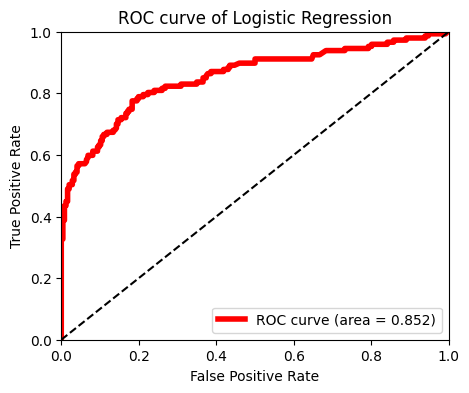

In [29]:
x_train, y_train = df_train.loc[:, df_train.columns != 'survived'].values, df_train['survived'].values
x_test, y_test = df_test.loc[:, df_test.columns != 'survived'].values, df_test['survived'].values

lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

# 학습한 모델의 성능을 계산하여 출력
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision: %.3f" % precision_score(y_test, y_pred))
print("Recall: %.3f" % recall_score(y_test, y_pred))
print("F1: %.3f" % f1_score(y_test, y_pred))

# 학습한 모델의 AUC를 계산하여 출력
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" %roc_auc)

# ROC curve를 그래프로 출력
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %.3f)' %roc_auc, color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic Regression')
plt.legend(loc='lower right')

위의 그래프를 보면 auc 점수가 이전보다 0.1 정도 증가한 것을 알 수 있다. 

아래의 코드는 분류 모델의 피처 영향력을 그래프로 살펴본 것이다. 이를 통해 피처 엔지니어링으로 생성된 name, cabin 피처의 영향력이 큰 것을 알 수 있다.

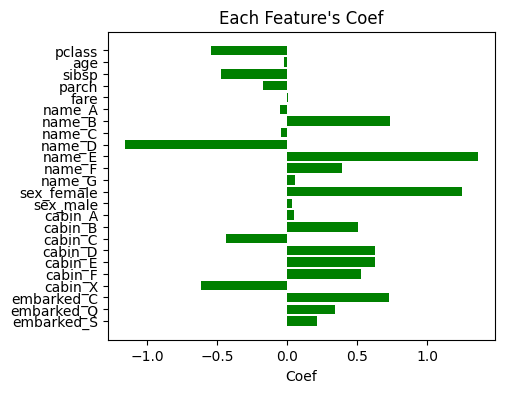

In [30]:
# 예측 대상인 survived 피처를 제외한 모든 피처를 리스트로 변환
cols = df_train.columns.tolist()
cols.remove('survived')
y_pos = np.arange(len(cols))

# 각 피처별 회귀 분석 계수를 그래프의 x축으로 하여 피처 영향력의 그래프를 출력
plt.rcParams['figure.figsize'] = [5, 4]
fig, ax = plt.subplots()
ax.barh(y_pos, lr.coef_[0], align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(cols)
ax.invert_yaxis()
ax.set_xlabel('Coef')
ax.set_title("Each Feature's Coef")

plt.show()

## Step 4 평가: 모델 검증하기

마지막 단계는 완성된 분류 모델을 검증하는 단계이다. 이를 위해 **모델의 과적합 여부**를 검증해야 한다. 방법은 2가지가 있는데
* K-fold 교차 검증
* 학습 곡선을 살펴보는 방법이다.

K-fold 교차 검증을 수행하기 위한 코드는 아래와 같다.

C:\Users\CHOYS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\CHOYS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

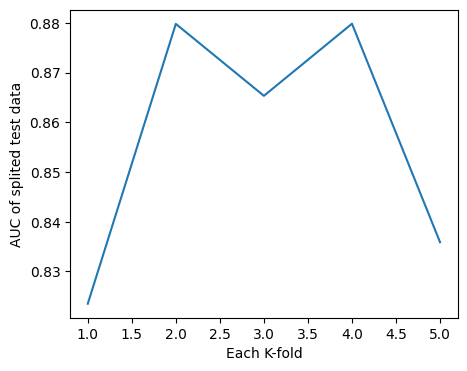

In [31]:
from sklearn.model_selection import KFold

# K-fold 교차 검증의 k를 5로 설정
k = 5
cv = KFold(k, shuffle=True, random_state=0)
auc_history = []

# K-fold를 5번의 분할 학습으로 반복
for i, (train_data_row, test_data_row) in enumerate(cv.split(whole_df_encoded)):

    # 5개로 분할된 fold 중 4개를 학습 데이터셋, 1개를 테스트 데이터셋으로 지정. 매 반복마다 테스트 데이터셋은 변경
    df_train = whole_df_encoded.iloc[train_data_row]
    df_test = whole_df_encoded.iloc[test_data_row]

    # survived 피처를 y, 나머지 피처들을 x 데이터로 지정
    splited_x_train, splited_y_train = df_train.loc[:, df_train.columns != 'survived'].values, df_train['survived'].values
    splited_x_test, splited_y_test = df_test.loc[:, df_test.columns != 'survived'].values, df_test['survived'].values

    # 주어진 데이터로 로지스틱 회귀 모델을 학습
    lr = LogisticRegression(random_state=0)
    lr.fit(splited_x_train, splited_y_train)
    y_pred = lr.predict(splited_x_test)
    y_pred_probability = lr.predict_proba(splited_x_test)[:,1]

    # 테스트 데이터셋의 AUC를 계산하며 auc_history에 저장
    false_positive_rate, true_positive_rate, threshold = roc_curve(splited_y_test, y_pred_probability)
    roc_auc = roc_auc_score(splited_y_test, y_pred_probability)
    auc_history.append(roc_auc)

# auc_history에 저장된 다섯 번의 학습 결과(AUC)를 그래프로 출력
plt.xlabel("Each K-fold")
plt.ylabel("AUC of splited test data")
plt.plot(range(1, k+1), auc_history)

위의 결과를 보면, AUC가 큰 폭으로 변화하고 있는 것을 볼 수 있다. 이는 불안정한 모델이라 할 수 있고, 아마 데이터의 개수가 적어서 발생하는 현상일 것이다. 또한 모든 실행에서 Test AUC가 0.8 이상의 수치를 기록했기 때문에 이 분류모델은 '과적합은 발생했지만 대체로 높은 정확도를 가지는 모델'이라고 할 수 있다.

학습 데이터와 테스트 데이터의 점수가 벌어지는 과적합 상황은 학습 곡선을 관찰함으로써 더 쉽게 관찰할 수 있다. 아래의 그래프는 학습 데이터 샘플의 개수가 증가함에 따라 학습과 테스트 두 점수가 어떻게 변화하는지를 관찰한 그래프이다.

C:\Users\CHOYS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\CHOYS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

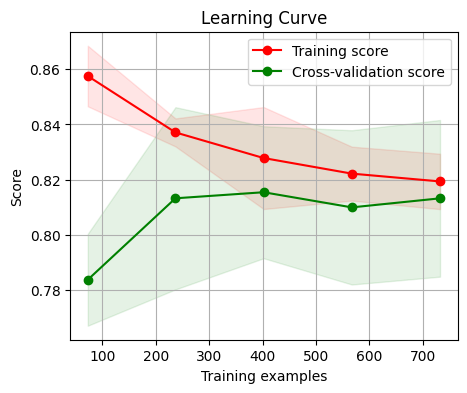

In [32]:
import scikitplot as skplt
skplt.estimators.plot_learning_curve(lr, x_train, y_train)
plt.show()

위의 그래프를 통해 샘플이 300개 이상부터 과적합의 위험이 낮아지는 것을 알 수 있다.